/tmp/ipykernel_4776/465165885.py:29: DeprecationWarning: Non-descriptor Image constructor called. This will stop working in 2026. Use create_image instead (with the same arguments).
  image_input = cl.Image(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, image_format, shape=(image.shape[1], image.shape[0]), hostbuf=image_rgba)
/tmp/ipykernel_4776/465165885.py:30: DeprecationWarning: Non-descriptor Image constructor called. This will stop working in 2026. Use create_image instead (with the same arguments).
  image_output = cl.Image(ctx, mf.WRITE_ONLY, image_format, shape=(image.shape[1], image.shape[0]))


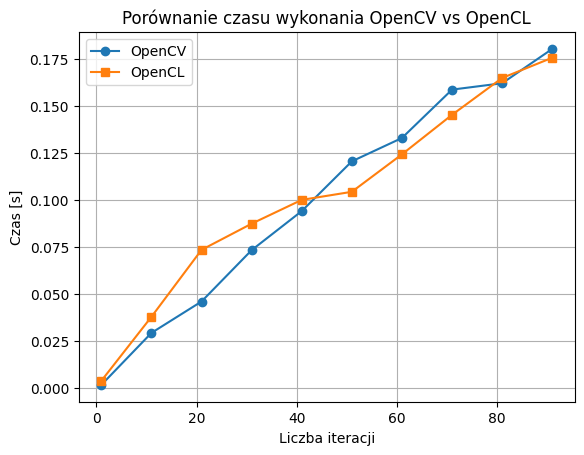

In [21]:
import cv2
import numpy as np
import pyopencl as cl
import time
import matplotlib.pyplot as plt

def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = np.resize(image, (4096, 4096))
    return image

# Wczytaj obraz testowy
image = load_image("/home/plorenc/Desktop/AiR_ISS/OpenCL/lab3/SobelFilterImage_Input.bmp")

# OpenCV Setup
kernel_size = 3
iterations = list(range(1, 101, 10))  # Użyjemy 10 iteracji
opencv_times = []
opencl_times = []

# **OpenCL Setup**
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags

# Konwersja do obrazu RGBA
image_rgba = cv2.cvtColor(image, cv2.COLOR_GRAY2RGBA)
image_format = cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.UNSIGNED_INT8)
image_input = cl.Image(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, image_format, shape=(image.shape[1], image.shape[0]), hostbuf=image_rgba)
image_output = cl.Image(ctx, mf.WRITE_ONLY, image_format, shape=(image.shape[1], image.shape[0]))

kernel_code = """
#define KERNEL_WIDTH 5
#define KERNEL_HEIGHT 3
#define KERNEL_STD 1.0f

float gaussian_kernel[KERNEL_HEIGHT][KERNEL_WIDTH];
float gaussian_sum = 0.0f;

__constant sampler_t imageSampler = CLK_NORMALIZED_COORDS_FALSE | CLK_ADDRESS_CLAMP | CLK_FILTER_NEAREST;

float gaussian_function(int x, int y, float std) {
    return exp(-((x * x + y * y) / (2.0f * std * std))) / (2.0f * M_PI * std * std);
}

void compute_gaussian_kernel() {
    int kernel_half_x = KERNEL_WIDTH / 2;
    int kernel_half_y = KERNEL_HEIGHT / 2;
    gaussian_sum = 0.0f;
    
    for (int y = -kernel_half_y; y <= kernel_half_y; y++) {
        for (int x = -kernel_half_x; x <= kernel_half_x; x++) {
            gaussian_kernel[y + kernel_half_y][x + kernel_half_x] = gaussian_function(x, y, KERNEL_STD);
            gaussian_sum += gaussian_kernel[y + kernel_half_y][x + kernel_half_x];
        }
    }
}

__kernel void gausse_filter(__read_only image2d_t inputImage, __write_only image2d_t outputImage) {
    int2 pos = (int2)(get_global_id(0), get_global_id(1));
    
    float3 color = (float3)(0.0f, 0.0f, 0.0f);
    
    int kernel_half_x = KERNEL_WIDTH / 2;
    int kernel_half_y = KERNEL_HEIGHT / 2;
    
    if (gaussian_sum == 0.0f) {
        compute_gaussian_kernel();
    }

    for (int dy = -kernel_half_y; dy <= kernel_half_y; dy++) {
        for (int dx = -kernel_half_x; dx <= kernel_half_x; dx++) {
            int2 offset = pos + (int2)(dx, dy);
            float4 pixel = read_imagef(inputImage, imageSampler, offset);
            
            float weight = gaussian_kernel[dy + kernel_half_y][dx + kernel_half_x];
            color += pixel.xyz * weight;
        }
    }
    
    color /= gaussian_sum;
    write_imagef(outputImage, pos, (float4)(color, 1.0f));
}

"""

# Kompilacja kernela
program = cl.Program(ctx, kernel_code).build()

total_size = (image.shape[1], image.shape[0])

# **Rozgrzanie GPU przed testem**
event = program.gausse_filter(queue, total_size, None, image_input, image_output)
event.wait()
queue.finish()

# **Wykonanie testów dla każdej liczby iteracji w iterations**
for num_iter in iterations:
    # **Test OpenCV**
    start_time = time.time()
    for _ in range(num_iter):
        opencv_eroded = cv2.GaussianBlur(image, (3, 3), 1)
    opencv_times.append(time.time() - start_time)

    # **Test OpenCL (czysty czas wykonania kernela)**
    queue.finish()  # Upewniamy się, że wszystkie operacje są zakończone
    start_time = time.time()
    for _ in range(num_iter):
        event = program.gausse_filter(queue, total_size, None, image_input, image_output)
        event.wait()  # Czekamy tylko na wykonanie kernela
    queue.finish()
    opencl_times.append(time.time() - start_time)

# **Kopiowanie wyników GPU → CPU po testach**
output_np = np.empty_like(image_rgba)
cl.enqueue_copy(queue, output_np, image_output, origin=(0, 0), region=(image.shape[1], image.shape[0])).wait()

# **Wykres czasu wykonania**
plt.plot(iterations, opencv_times[:len(iterations)], label="OpenCV", marker='o')  # Upewniamy się, że długości list są zgodne
plt.plot(iterations, opencl_times[:len(iterations)], label="OpenCL", marker='s')
plt.xlabel("Liczba iteracji")
plt.ylabel("Czas [s]")
plt.title("Porównanie czasu wykonania OpenCV vs OpenCL")
plt.legend()
plt.grid()
plt.show()


/tmp/ipykernel_4776/1835545602.py:29: DeprecationWarning: Non-descriptor Image constructor called. This will stop working in 2026. Use create_image instead (with the same arguments).
  image_input = cl.Image(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, image_format, shape=(image.shape[1], image.shape[0]), hostbuf=image_rgba)
/tmp/ipykernel_4776/1835545602.py:30: DeprecationWarning: Non-descriptor Image constructor called. This will stop working in 2026. Use create_image instead (with the same arguments).
  image_output = cl.Image(ctx, mf.WRITE_ONLY, image_format, shape=(image.shape[1], image.shape[0]))


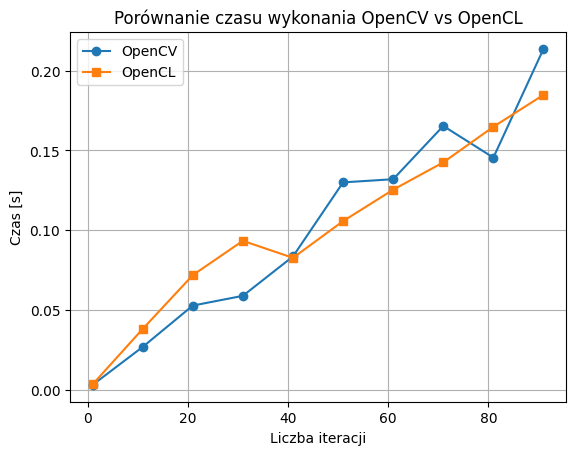

In [64]:
import cv2
import numpy as np
import pyopencl as cl
import time
import matplotlib.pyplot as plt

def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = np.resize(image, (4096, 4096))
    return image

# Wczytaj obraz testowy
image = load_image("/home/plorenc/Desktop/AiR_ISS/OpenCL/lab3/SobelFilterImage_Input.bmp")

# OpenCV Setup
kernel_size = 3
iterations = list(range(1, 101, 10))  # Użyjemy 10 iteracji
opencv_times = []
opencl_times = []

# **OpenCL Setup**
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags

# Konwersja do obrazu RGBA
image_rgba = cv2.cvtColor(image, cv2.COLOR_GRAY2RGBA)
image_format = cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.UNSIGNED_INT8)
image_input = cl.Image(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, image_format, shape=(image.shape[1], image.shape[0]), hostbuf=image_rgba)
image_output = cl.Image(ctx, mf.WRITE_ONLY, image_format, shape=(image.shape[1], image.shape[0]))

kernel_code = """
#define KERNEL_WIDTH 5
#define KERNEL_HEIGHT 3
#define KERNEL_STD 1.0f

float gaussian_kernel[KERNEL_HEIGHT][KERNEL_WIDTH];
float gaussian_sum = 0.0f;

__constant sampler_t imageSampler = CLK_NORMALIZED_COORDS_FALSE | CLK_ADDRESS_CLAMP | CLK_FILTER_NEAREST;

float gaussian_function(int x, int y, float std) {
    return exp(-((x * x + y * y) / (2.0f * std * std))) / (2.0f * M_PI * std * std);
}

void compute_gaussian_kernel() {
    int kernel_half_x = KERNEL_WIDTH / 2;
    int kernel_half_y = KERNEL_HEIGHT / 2;
    gaussian_sum = 0.0f;
    
    for (int y = -kernel_half_y; y <= kernel_half_y; y++) {
        for (int x = -kernel_half_x; x <= kernel_half_x; x++) {
            gaussian_kernel[y + kernel_half_y][x + kernel_half_x] = gaussian_function(x, y, KERNEL_STD);
            gaussian_sum += gaussian_kernel[y + kernel_half_y][x + kernel_half_x];
        }
    }
}

__kernel void gausse_filter(__read_only image2d_t inputImage, __write_only image2d_t outputImage) {
    int2 pos = (int2)(get_global_id(0), get_global_id(1));
    
    float3 color = (float3)(0.0f, 0.0f, 0.0f);
    
    int kernel_half_x = KERNEL_WIDTH / 2;
    int kernel_half_y = KERNEL_HEIGHT / 2;
    
    // Jeśli sumowanie jest równe 0, oblicz filtr Gaussa
    if (gaussian_sum == 0.0f) {
        compute_gaussian_kernel();
    }

    // Zastosuj pełną 2D macierz filtru na obrazie
    for (int dy = -kernel_half_y; dy <= kernel_half_y; dy++) {
        for (int dx = -kernel_half_x; dx <= kernel_half_x; dx++) {
            int2 offset = pos + (int2)(dx, dy);
            float4 pixel = read_imagef(inputImage, imageSampler, offset);
            
            float weight = gaussian_kernel[dy + kernel_half_y][dx + kernel_half_x];
            color += pixel.xyz * weight;
        }
    }
    
    // Normalizuj wynik przez sumę wag
    color /= gaussian_sum;
    
    // Zapisz wynik do obrazu wyjściowego
    write_imagef(outputImage, pos, (float4)(color, 1.0f));
}


"""

# Kompilacja kernela
program = cl.Program(ctx, kernel_code).build()

total_size = (image.shape[1], image.shape[0])

# **Rozgrzanie GPU przed testem**
event = program.gausse_filter(queue, total_size, None, image_input, image_output)
event.wait()
queue.finish()

# **Wykonanie testów dla każdej liczby iteracji w iterations**
for num_iter in iterations:
    # **Test OpenCV**
    start_time = time.time()
    for _ in range(num_iter):
        opencv_eroded = cv2.GaussianBlur(image, (3, 3), 1)
    opencv_times.append(time.time() - start_time)

    # **Test OpenCL (czysty czas wykonania kernela)**
    queue.finish()  # Upewniamy się, że wszystkie operacje są zakończone
    start_time = time.time()
    for _ in range(num_iter):
        event = program.gausse_filter(queue, total_size, None, image_input, image_output)
        event.wait()  # Czekamy tylko na wykonanie kernela
    queue.finish()
    opencl_times.append(time.time() - start_time)

# **Kopiowanie wyników GPU → CPU po testach**
output_np = np.empty_like(image_rgba)
cl.enqueue_copy(queue, output_np, image_output, origin=(0, 0), region=(image.shape[1], image.shape[0])).wait()

# **Wykres czasu wykonania**
plt.plot(iterations, opencv_times[:len(iterations)], label="OpenCV", marker='o')  # Upewniamy się, że długości list są zgodne
plt.plot(iterations, opencl_times[:len(iterations)], label="OpenCL", marker='s')
plt.xlabel("Liczba iteracji")
plt.ylabel("Czas [s]")
plt.title("Porównanie czasu wykonania OpenCV vs OpenCL")
plt.legend()
plt.grid()
plt.show()


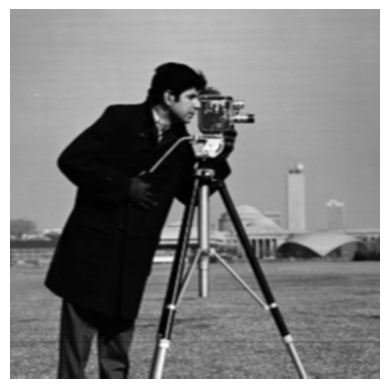

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ścieżka do obrazu
img_path = '/home/plorenc/Desktop/AiR_ISS/OpenCL/lab6/SobelFilterImage_Input.bmp'

# Wczytanie obrazu w formacie odcieni szarości
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Jeśli rozmiar obrazu nie wynosi 512x512, można go dostosować
img = cv2.resize(img, (512, 512))

# Nałożenie filtru Gaussa 15x15
blurred_img = cv2.GaussianBlur(img, (5, 3), 3)

# Wyświetlenie obrazu
plt.imshow(blurred_img, cmap='gray')
plt.axis('off')  # Wyłączenie osi
plt.show()


In [51]:
img.shape

(384, 512)